In [1]:
import pickle

# Load the saved data
all_data = None
with open('all_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)
    all_data = loaded_data

Processing IBM...
Processing NFLX...
Processing MSFT...
Processing COST...
Processing KO...
Processing TSM...
Processing CRWD...
Processing AAPL...
Processing GOOGL...
Processing SMCI...
Processing PFE...
Processing INTC...
Processing BAC...
Processing TSLA...
Processing NVDA...
Processing META...
Processing GOOG...
Processing AMZN...
Processing LLY...
Processing NVO...
Processing ORCL...
Processing PLTR...
Processing AVGO...
Processing JPM...
Processing AMD...
Processing ASML...


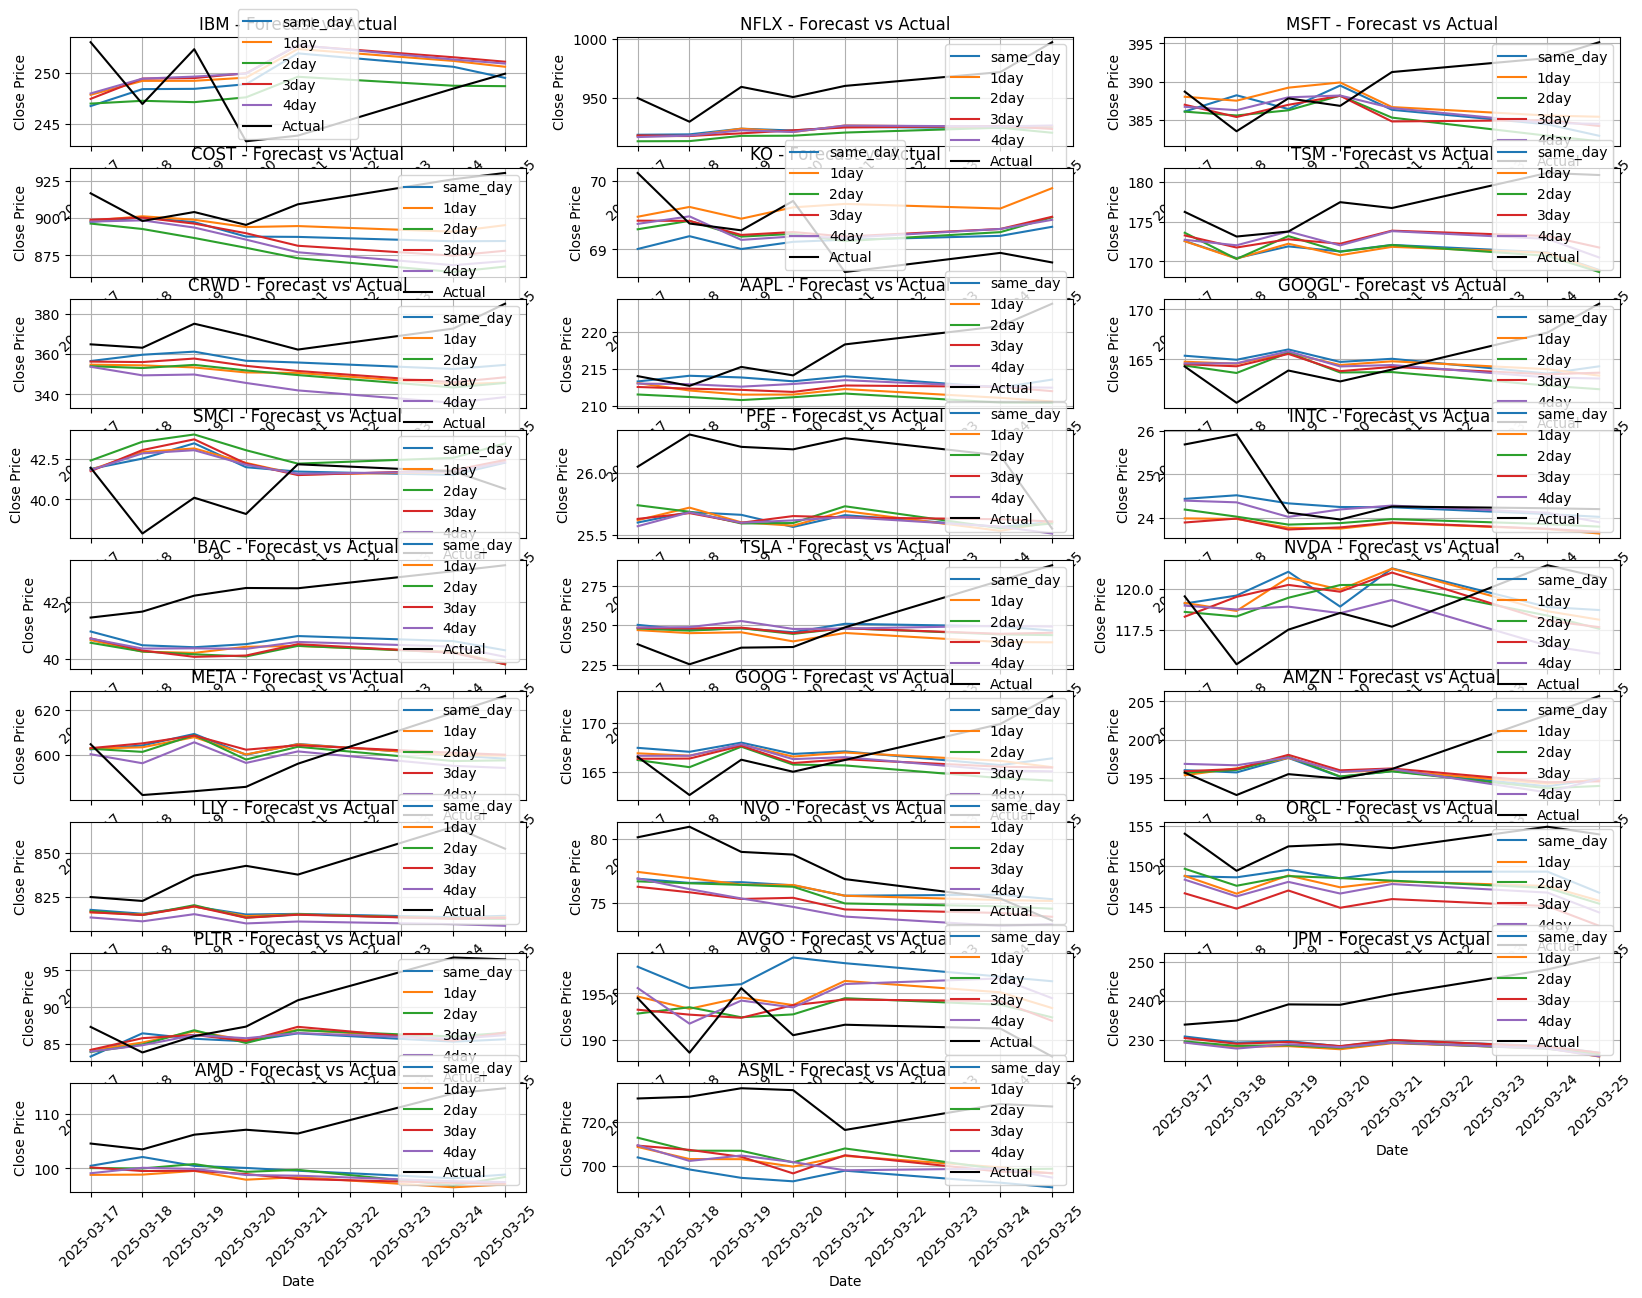


Direction Accuracy by Variant:
    Variant  Direction_Accuracy
0      1day           51.923077
1      2day           50.000000
2      3day           52.564103
3      4day           52.564103
4  same_day           50.000000

Direction Accuracy by Ticker:
   Ticker  Direction_Accuracy
7    CRWD           76.666667
11   INTC           76.666667
21    PFE           73.333333
2    AMZN           73.333333
4    AVGO           73.333333
9   GOOGL           70.000000
19    NVO           70.000000
17   NFLX           66.666667
8    GOOG           60.000000
13     KO           60.000000
20   ORCL           56.666667
24   TSLA           53.333333
25    TSM           50.000000
12    JPM           50.000000
18   NVDA           46.666667
15   META           43.333333
0    AAPL           40.000000
6    COST           40.000000
3    ASML           40.000000
14    LLY           40.000000
23   SMCI           36.666667
1     AMD           36.666667
16   MSFT           30.000000
10    IBM           30.00

In [8]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
import warnings

import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Define the forecast period
test_start = datetime.strptime('2025-03-17', '%Y-%m-%d').date()
test_end = datetime.strptime('2025-03-25', '%Y-%m-%d').date()

# Define the exogenous variables
exog_cols = ['positive', 'negative', 'neutral', 'culmination']

# Define ticker list and variants
tickers = list(all_data.keys())
variants = ['same_day', '1day', '2day', '3day', '4day']

# Create a results dataframe to store evaluation metrics
results = []

# Create a figure for each ticker
plt.figure(figsize=(20, 15))
fig_count = len(tickers)
fig_cols = 3
fig_rows = (fig_count + fig_cols - 1) // fig_cols

for ticker_idx, ticker in enumerate(tickers):
    print(f"Processing {ticker}...")
    
    # Create a subplot for this ticker
    plt.subplot(fig_rows, fig_cols, ticker_idx + 1)
    
    # Store actual values to plot later
    actual_values = None
    
    # Process each variant
    for variant in variants:
        # Get the data for this variant
        df = all_data[ticker][variant]
        
        # Make sure date is the index
        if 'date' in df.columns:
            df.set_index('date', inplace=True)
        
        # Split data into train and test
        train_data = df[df.index < test_start]
        test_data = df[(df.index >= test_start) & (df.index <= test_end)]
        
        # If test data is empty, skip this variant
        if test_data.empty:
            print(f"  No test data for {ticker} ({variant}), skipping")
            continue
            
        # Store the actual close prices for plotting
        if actual_values is None:
            actual_values = test_data['close']
        
        # Define X and y
        y_train = train_data['close']
        X_train = train_data[exog_cols]
        
        X_test = test_data[exog_cols]
        
        # Fit SARIMAX model
        model = SARIMAX(y_train, 
                       exog=X_train,
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 5),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
        
        try:
            model_fit = model.fit(disp=False)
            
            # Make predictions
            predictions = model_fit.forecast(steps=len(X_test), exog=X_test)
            
            # Calculate direction accuracy
            if len(predictions) >= 2 and len(test_data) >= 2:
                # Calculate direction changes for all consecutive days in predictions
                pred_changes = np.diff(predictions)
                pred_directions = np.sign(pred_changes)
                
                # Calculate direction changes for all consecutive days in actual data
                actual_changes = np.diff(test_data['close'])
                actual_directions = np.sign(actual_changes)
                
                # Match predictions with actual directions
                correct_directions = sum(p_dir == a_dir for p_dir, a_dir in zip(pred_directions, actual_directions))
                total_directions = len(pred_directions)
                
                # Calculate accuracy percentage
                if total_directions > 0:
                    direction_accuracy = (correct_directions / total_directions) * 100
                else:
                    direction_accuracy = np.nan
                    
                # Handle cases where direction is flat (no change)
                flat_cases = sum((p_dir == 0) | (a_dir == 0) for p_dir, a_dir in zip(pred_directions, actual_directions))
                if flat_cases > 0:
                    # Adjust accuracy calculation to give 50% credit for flat predictions
                    adjusted_correct = correct_directions + (flat_cases * 0.5)
                    direction_accuracy = (adjusted_correct / total_directions) * 100
            else:
                direction_accuracy = np.nan
            
            # Calculate traditional metrics
            mse = ((predictions - test_data['close']) ** 2).mean()
            rmse = np.sqrt(mse)
            mae = (abs(predictions - test_data['close'])).mean()
            
            # Store results
            results.append({
                'Ticker': ticker,
                'Variant': variant,
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'Direction_Accuracy': direction_accuracy
            })
            
            # Plot the predictions
            plt.plot(test_data.index, predictions, label=f'{variant}')
            
        except Exception as e:
            print(f"  Error with {ticker} ({variant}): {str(e)}")
    
    # Plot the actual values
    if actual_values is not None:
        plt.plot(actual_values.index, actual_values, 'k-', label='Actual')
    
    plt.title(f'{ticker} - Forecast vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
plt.show()

# Create a results dataframe
results_df = pd.DataFrame(results)

# Add a summary by variant
variant_summary = results_df.groupby('Variant')['Direction_Accuracy'].mean().reset_index()
print("\nDirection Accuracy by Variant:")
print(variant_summary)

# Add a summary by ticker
ticker_summary = results_df.groupby('Ticker')['Direction_Accuracy'].mean().reset_index()
print("\nDirection Accuracy by Ticker:")
print(ticker_summary.sort_values('Direction_Accuracy', ascending=False))